In [1]:

import subprocess
import sys
sys.path.insert(0,'..')
from pathlib import Path
import os
import random

import torch
import torch.nn as nn
from torch.nn.functional import one_hot
from torch import Tensor
from typing import Union

import matplotlib.pylab as plt

import time
import numpy as np
import torch as th
import torch.nn as nn
from torch.utils import data
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, WeightedRandomSampler
import torch.optim.lr_scheduler as lr_scheduler

# from focal_loss import FocalLoss
from utils import _axat, _atxa, _mvmt
import seaborn as sns


def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package],
                         stdout=subprocess.DEVNULL,
                         stderr=subprocess.DEVNULL
                         )
required_packages = [
    "geoopt",
    "pyriemann",
]
for package in required_packages:
    try:
        __import__(package)
        print(f"{package} is already installed.")
    except ImportError:
        print(f"{package} is not installed. Installing...")
        install(package)

import geoopt
from pyriemann.utils.covariance import covariances, normalize


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.manifold import TSNE
import pandas as pd


use_cuda = th.cuda.is_available()
device = th.device("cuda:0" if use_cuda else "cpu")
print(device)

geoopt is not installed. Installing...
pyriemann is not installed. Installing...
cuda:0


In [2]:
class FocalLoss(nn.Module):
    """Computes the focal loss between input and target
    as described here https://arxiv.org/abs/1708.02002v2

    Args:
        gamma (float):  The focal loss focusing parameter.
        weights (Union[None, Tensor]): Rescaling weight given to each class.
        If given, has to be a Tensor of size C. optional.
        reduction (str): Specifies the reduction to apply to the output.
        it should be one of the following 'none', 'mean', or 'sum'.
        default 'mean'.
        ignore_index (int): Specifies a target value that is ignored and
        does not contribute to the input gradient. optional.
        eps (float): smoothing to prevent log from returning inf.
    """
    def __init__(
            self,
            gamma,
            weights: Union[None, Tensor] = None,
            reduction: str = 'mean',
            ignore_index=-100,
            eps=1e-16
            ) -> None:
        super().__init__()
        if reduction not in ['mean', 'none', 'sum']:
            raise NotImplementedError(
                'Reduction {} not implemented.'.format(reduction)
                )
        assert weights is None or isinstance(weights, Tensor), \
            'weights should be of type Tensor or None, but {} given'.format(
                type(weights))
        self.reduction = reduction
        self.gamma = gamma
        self.ignore_index = ignore_index
        self.eps = eps
        self.weights = weights

    def _get_weights(self, target: Tensor) -> Tensor:
        if self.weights is None:
            return torch.ones(target.shape[0])
        weights = target * self.weights
        return weights.sum(dim=-1)

    def _process_target(
            self, target: Tensor, num_classes: int, mask: Tensor
            ) -> Tensor:
        
        #convert all ignore_index elements to zero to avoid error in one_hot
        #note - the choice of value 0 is arbitrary, but it should not matter as these elements will be ignored in the loss calculation
        target = target * (target!=self.ignore_index) 
        target = target.view(-1)
        return one_hot(target, num_classes=num_classes)

    def _process_preds(self, x: Tensor) -> Tensor:
        if x.dim() == 1:
            x = torch.vstack([1 - x, x])
            x = x.permute(1, 0)
            return x
        return x.view(-1, x.shape[-1])

    def _calc_pt(
            self, target: Tensor, x: Tensor, mask: Tensor
            ) -> Tensor:
        p = target * x
        p = p.sum(dim=-1)
        p = p * ~mask
        return p

    def forward(self, x: Tensor, target: Tensor) -> Tensor:
        assert torch.all((x >= 0.0) & (x <= 1.0)), ValueError(
            'The predictions values should be between 0 and 1, \
                make sure to pass the values to sigmoid for binary \
                classification or softmax for multi-class classification'
        )
        mask = target == self.ignore_index
        mask = mask.view(-1)
        x = self._process_preds(x)
        num_classes = x.shape[-1]
        target = self._process_target(target, num_classes, mask)
        weights = self._get_weights(target).to(x.device)
        pt = self._calc_pt(target, x, mask)
        focal = 1 - pt
        nll = -torch.log(self.eps + pt)
        nll = nll.masked_fill(mask, 0)
        loss = weights * (focal ** self.gamma) * nll
        return self._reduce(loss, mask, weights)

    def _reduce(self, x: Tensor, mask: Tensor, weights: Tensor) -> Tensor:
        if self.reduction == 'mean':
            return x.sum() / (~mask * weights).sum()
        elif self.reduction == 'sum':
            return x.sum()
        else:
            return x

In [3]:
class BusemanSimilarityClassifier(nn.Module):
    def busemann_spd(self, logM):
        """
        Compute the Busemann similarity for Symmetric Positive Definite (SPD) matrices.
        
        :param logM: Logarithm of SPD matrices, shape (b, n, n)
        :return: Similarity scores, shape (b, n_proto)
        """
        return logM.reshape(logM.shape[0], -1) @ self.proto.reshape(self.proto.shape[0], -1).T
    def __init__(self,dim1,n_proto,n_classes,optim_proto=True):
        super().__init__()
        self.n_proto = n_proto
        self.n_classes = n_classes
        self.dim1 = dim1
        
        self.manifold = geoopt.Stiefel()

        # Random projection directions, shape (d-1, num_projections)
        theta = np.random.normal(size=(self.n_proto, self.dim1))
        theta = th.nn.functional.normalize(th.from_numpy(theta), p=2, dim=-1).type(th.float64).to(device)
        #self.D = theta[:,None] * th.eye(theta.shape[-1],dtype=th.float64, device=device)
        self.register_parameter("theta_proto", geoopt.ManifoldParameter(theta, geoopt.Sphere()))
        #self.theta_proto=theta

        ## Random orthogonal matrices
        Z = th.randn((self.n_proto, self.dim1, self.dim1), dtype=th.float64, device=device)
        self.Q = th.svd(Z)[0]
        self.manifold.assert_check_point_on_manifold(self.Q)
        self.register_parameter("Q_proto", geoopt.ManifoldParameter(self.Q, self.manifold))
        self.proto = _mvmt(self.Q_proto, self.theta_proto, self.Q_proto)
        # linear layer
        self.linear = nn.Linear(self.n_proto, self.n_classes).double()

    def forward(self, x):
        self.proto = _mvmt(self.Q_proto, self.theta_proto, self.Q_proto)
        y = self.linear(self.busemann_spd(x))#.view(sim_embedding.shape[0], -1))
        return y
    
    def embed(self, x):
        self.proto = _mvmt(self.Q_proto, self.theta_proto, self.Q_proto)
        return self.busemann_spd(x)

# Model definition

In [4]:
class LogEucRResNet(nn.Module):
    def __init__(self, inputdim=10, dim1=7, n_proto=12, classes=11, embed_only=False):
        super().__init__()
        self.inputdim = inputdim
        self.dim1 = dim1
        self.n_proto = n_proto
        self.classes = classes
        self.embed_only = embed_only

        self.manifold_Stiefel = geoopt.Stiefel()
        self.manifold_SPD = geoopt.SymmetricPositiveDefinite("LEM")
        
        # init first bimap
        bm1 = th.randn((1, self.inputdim, self.dim1), dtype=th.float64)
        bm1 = th.svd(bm1)[0]
        self.register_parameter("bimap1", geoopt.ManifoldParameter(bm1, self.manifold_Stiefel))
        
        P = th.randn((1, self.dim1, self.dim1), dtype=th.float64)
        P = th.svd(P)[0]

        self.register_parameter("P1", geoopt.ManifoldParameter(P, self.manifold_Stiefel))

        self.classiflayer=BusemanSimilarityClassifier(self.dim1,self.n_proto, classes)
        self.fc_layer = nn.Linear(self.dim1 * self.dim1, self.classes).double()
        self.softmax =  nn.Softmax(dim=-1)

        self.spectrum_map = nn.Sequential(
            nn.Conv1d(1, 10, 5, padding="same").double(),
            nn.LeakyReLU(),
            nn.BatchNorm1d(10).double(),
            nn.Conv1d(10, 5, 3, padding="same").double(),
            nn.LeakyReLU(),
            nn.BatchNorm1d(5).double(),
            nn.Conv1d(5, 1, 3, padding="same").double(),
        )
        
    def forward(self, x):
        x = _atxa(self.bimap1, x)
        evecs, eigs, _ = th.svd(x)
        f_eigs = self.spectrum_map(eigs) # spectral map
        v1 = _mvmt(self.P1, f_eigs, self.P1)            
        v1 = self.manifold_SPD.proju(x, v1)
        eigs = th.clamp(eigs, 1e-8, 1e8)
        log_x = _mvmt(evecs, th.log(eigs), evecs)     
        x = log_x + v1
        if self.embed_only:
            return x.reshape(x.shape[0],-1)
        return self.softmax(self.fc_layer(x.reshape(x.shape[0],-1)))
        #return self.softmax(self.classiflayer(x)) # Buseman Similarity Classifier when single modality is used
            
class LogEucRResNet_Combo(nn.Module):
    def __init__(self, inputdim_temp=36, dim1_temp=24, inputdim_spec=10, dim1_spec=7, n_proto=12, classes=11, buseman_classif=True):
        super().__init__()
        self.classes = classes
        self.buseman_classif = buseman_classif
        self.model_temp = LogEucRResNet(inputdim_temp, dim1_temp, n_proto, embed_only=True)
        self.model_spectral = LogEucRResNet(inputdim_spec, dim1_spec, n_proto, embed_only=True)
        
        self.classiflayer = BusemanSimilarityClassifier(dim1_temp+1,n_proto,classes)
        self.fc_layer = nn.Linear(dim1_temp*dim1_temp+dim1_spec*dim1_spec,classes).double()        
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x1, x2):
        out_1 = self.model_temp(x1) # probabilities
        out_2 = self.model_spectral(x2) # probabilities
        x = th.concat((out_1, out_2), dim=1)
        #print(x.shape)
        if self.buseman_classif:
            return self.softmax(self.classiflayer(x))
        else:
            return self.softmax(self.fc_layer(x))

Create model and load it from file 

In [5]:
model = LogEucRResNet_Combo(buseman_classif=False).to(device)
model.eval()
# get number of trainable parameters
trainable_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(trainable_total_params)

/opt/conda/lib/python3.10/site-packages/geoopt/manifolds/symmetric_positive_definite.py:52: UserWarning: SPDMetric.LEM is not fully implemented and results may be not as you expect
  warnings.warn(


31965


## visualize dataset embedding

load dataset

In [6]:
class TS_COV(Dataset):
    def __init__(self, root_dir, np_file, estimator='scm'):
        self.root_dir = root_dir
        self.np_file = np_file
        self.estimator = estimator
        self.x, self.y, self.class_names = self.load_data()
        #self.cov = normalize(self.calculate_covariances(),'corr')
        self.x1 = self.calculate_covariances_36()
        self.x2 = self.calculate_covariances_10()
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x1, x2= self.x1[idx], self.x2[idx]
        y_sample = self.y[idx]
        class_name = self.class_names[y_sample]
        x1 = th.from_numpy(np.asarray([x1])).double()
        x2 = th.from_numpy(np.asarray([x2])).double()
        x1,x2 = x1.reshape(1, 36, 36), x2.reshape(1, 10, 10)
        y = th.from_numpy(np.array(y_sample)).long()
        return x1,x2, y#, class_name

    def load_data(self):
        file_path = os.path.join(self.root_dir, self.np_file)
        data = np.load(file_path, allow_pickle= True)
        x = data['series']
        y = data['labels']
        class_names = data['class_names']
        return x, y, class_names

    def calculate_covariances_10(self):
        x_transposed = np.transpose(self.x, (0, 2, 1))
        cov = covariances(x_transposed, estimator=self.estimator)
        return cov
    def calculate_covariances_36(self):
        cov = covariances(self.x, estimator=self.estimator)
        return cov
        


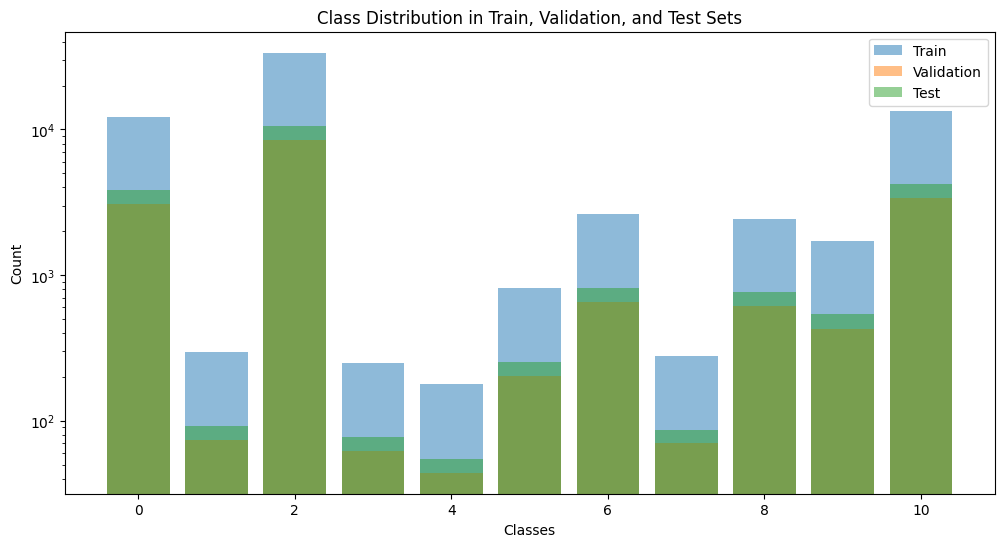

In [7]:
%matplotlib inline

root_dir = r"/kaggle/input/normalized-data/"
npz_file = "98_p_norm_data.npz"
batch_size = 64  # batch size

def calculate_class_weights(labels):
    class_sample_count = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])
    weight = 1 - class_sample_count / len(labels)
    return th.from_numpy(weight).double()

def create_data_loaders(dataset, train_indices, val_indices, test_indices, batch_size):
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_indices))
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(val_indices))
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(test_indices), shuffle=False)
    return train_loader, val_loader, test_loader

def plot_class_distribution(train_loader, val_loader, test_loader, n_classes):
    train_counts = np.zeros(n_classes)
    for _, _, labels in train_loader:
        for l in labels:
            train_counts[l] += 1

    val_counts = np.zeros(n_classes)
    for _, _, labels in val_loader:
        for l in labels:
            val_counts[l] += 1

    test_counts = np.zeros(n_classes)
    for _, _, labels in test_loader:
        for l in labels:
            test_counts[l] += 1

    plt.figure(figsize=(12, 6))
    plt.bar(np.arange(n_classes), train_counts, alpha=0.5, label='Train')
    plt.bar(np.arange(n_classes), val_counts, alpha=0.5, label='Validation')
    plt.bar(np.arange(n_classes), test_counts, alpha=0.5, label='Test')
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.yscale('log')
    plt.title('Class Distribution in Train, Validation, and Test Sets')
    plt.legend(loc='best')
    plt.show()

# Initialize dataset
dataset = TS_COV(root_dir=root_dir, np_file=npz_file, estimator='scm')

# Split data into train, validation, and test sets
train_indices, test_indices = train_test_split(list(range(len(dataset))), test_size=0.2, stratify=dataset.y, random_state=42)
train_indices, val_indices = train_test_split(train_indices, test_size=0.2, stratify=dataset.y[train_indices], random_state=42)

# Calculate class weights
weights = calculate_class_weights(dataset.y)
weights = weights.to(device)


# Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(dataset, train_indices, val_indices, test_indices, batch_size)

# Plot class distribution
plot_class_distribution(train_loader, val_loader, test_loader, n_classes=11)


In [8]:
# access one matri
for x1,x2, y in train_loader:
    print(x1.shape)
    print(x2.shape)
    print(y.shape)
    break

torch.Size([64, 1, 36, 36])
torch.Size([64, 1, 10, 10])
torch.Size([64])


In [9]:
lr=1e-2
epochs=200
gamma_value=0.95
step_size=30
#setup loss and optimizer
#loss_fn = nn.CrossEntropyLoss()
loss_fn = FocalLoss(gamma=1,weights=weights)
#opti = MixOptimizer(model.parameters(),lr=lr)
opti = geoopt.optim.RiemannianAdam(model.parameters(), lr=lr)
scheduler = lr_scheduler.ExponentialLR(opti, gamma=gamma_value)
#scheduler = lr_scheduler.StepLR(opti, step_size, gamma_value)

In [10]:
def train_model(model, train_loader, val_loader, loss_fn, optimizer, scheduler, epochs, combo=False, temp=False):
    t1, t2, t3, t4, t5 = [], [], [], [], []
    device = th.device("cuda" if th.cuda.is_available() else "cpu")

    for epoch in range(epochs):
        start_time = time.time()  # Start time of the epoch
        model.train()

        # Training phase
        loss_train, acc_train = [], []
        for x1, x2, y in train_loader:
            x1 = x1.to(device)
            x2 = x2.to(device)
            y = y.to(device).long()
            optimizer.zero_grad()
            
            # Conditional forward pass
            if combo:
                out = model(x1, x2)
            elif temp:
                out = model(x1)
            else:
                out = model(x2)
                
            l = loss_fn(out, y)
            
            acc, loss = (out.argmax(1) == y).cpu().numpy().sum() / out.shape[0], l.cpu().data.numpy()
            loss_train.append(loss)
            acc_train.append(acc)
            l.backward()
            optimizer.step()
        scheduler.step()

        acc_train = np.asarray(acc_train).mean()
        loss_train = np.asarray(loss_train).mean()
        t1.append(loss_train)
        t2.append(100 * acc_train)

        # Validation phase
        loss_val, acc_val_list = [], []
        y_true, y_pred = [], []
        model.eval()
        for x1, x2, y in val_loader:
            x1 = x1.to(device)
            x2 = x2.to(device)
            y = y.to(device).long()
            with th.no_grad():
                # Conditional forward pass
                if combo:
                    out = model(x1, x2)
                elif temp:
                    out = model(x1)
                else:
                    out = model(x2)
                    
                l = loss_fn(out, y)
                
            loss_val.append(l.cpu().data.numpy())
            predicted_labels = out.argmax(1)
            y_true.extend(list(y.cpu().numpy()))
            y_pred.extend(list(predicted_labels.cpu().numpy()))
            acc = (predicted_labels == y).cpu().numpy().sum() / out.shape[0]
            
            acc_val_list.append(acc)
        acc_val = np.asarray(acc_val_list).mean()
        loss_val = np.asarray(loss_val).mean()    
   
        t3.append(100 * acc_val)
        t4.append(loss_val)
        f1_test = f1_score(y_true, y_pred, average='macro')
        t5.append(100 * f1_test)
        print('Epoch {}/{} - Train loss: {:.4f} - Val loss: {:.4f} - Train acc: {:.2f}% - Val acc: {:.2f}% - Test F1-score: {:.2f}'.format(
            epoch + 1, epochs, loss_train, loss_val, 100 * acc_train, 100 * acc_val, 100 * f1_test))

        elapsed_time = time.time() - start_time
        print('Elapsed time: {:.2f} seconds'.format(elapsed_time))

    return t1, t2, t3, t4, t5


In [11]:

def evaluate_model(model, data_loader, loss_fn, model_name, figure_name, combo=True, temp=False):
    loss_val, acc_val = [], []
    y_true, y_pred = [], []

    model.eval()
    for x1, x2, y in data_loader:
        x1 = x1.to(device)
        x2 = x2.to(device)
        y = y.to(device).long()
        with th.no_grad():
            # Conditional forward pass
            if combo:
                out = model(x1, x2)
            elif temp:
                out = model(x1)
            else:
                out = model(x2)
                
            l = loss_fn(out, y)
        
        predicted_labels = out.argmax(1)
        y_true.extend(list(y.cpu().numpy()))
        y_pred.extend(list(predicted_labels.cpu().numpy()))
        acc = (predicted_labels == y).cpu().numpy().sum() / out.shape[0]
        loss_val.append(l.cpu().data.numpy())
        acc_val.append(acc)

    acc_val = np.asarray(acc_val).mean()
    loss_val = np.asarray(loss_val).mean()

    print('Validation loss: {:.4f}'.format(loss_val))
    print('Validation accuracy: {:.2f}%'.format(100 * acc_val))

    # Save the model
    th.save(model.state_dict(), f'{model_name}.ckpt')
    print(f'Model saved as {model_name}.ckpt')

    # Print classification report
    print(classification_report(y_true, y_pred, digits=2, target_names=data_loader.dataset.class_names))
    cmatrix = confusion_matrix(y_true, y_pred)
    Ncmatrix = cmatrix.astype('float') / cmatrix.sum(axis=1)[:, np.newaxis]

    group_counts = ['{0:0.0f}'.format(value) for value in cmatrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in Ncmatrix.flatten()]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(11, 11)

    # Plot and save the confusion matrix figure
    plt.figure(figsize=(10, 8))
    sns.heatmap(Ncmatrix, annot=labels, fmt='', cmap='Reds', xticklabels=data_loader.dataset.class_names, yticklabels=data_loader.dataset.class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label\n Acc={:.2f}%'.format(100 * acc_val))
    
    plt.savefig(f'{figure_name}.png')
    plt.show()
    print(f'Figure saved as {figure_name}.png')

    return 100 * acc_val


In [12]:
t1, t2, t3, t4, t5 = train_model(model, train_loader, val_loader, loss_fn, opti, scheduler, epochs, combo=True, temp=False)


Epoch 1/200 - Train loss: 0.5184 - Val loss: 0.3488 - Train acc: 89.57% - Val acc: 92.92% - Test F1-score: 70.17
Elapsed time: 30.11 seconds
Epoch 2/200 - Train loss: 0.3544 - Val loss: 0.3614 - Train acc: 92.41% - Val acc: 92.32% - Test F1-score: 69.72
Elapsed time: 27.60 seconds
Epoch 3/200 - Train loss: 0.3369 - Val loss: 0.3985 - Train acc: 93.20% - Val acc: 92.64% - Test F1-score: 71.33
Elapsed time: 27.34 seconds
Epoch 4/200 - Train loss: 0.3335 - Val loss: 0.4011 - Train acc: 93.62% - Val acc: 92.16% - Test F1-score: 73.10
Elapsed time: 27.32 seconds
Epoch 5/200 - Train loss: 0.3017 - Val loss: 0.4475 - Train acc: 94.14% - Val acc: 93.48% - Test F1-score: 72.50
Elapsed time: 27.62 seconds
Epoch 6/200 - Train loss: 0.2904 - Val loss: 0.3474 - Train acc: 94.38% - Val acc: 94.72% - Test F1-score: 76.06
Elapsed time: 27.31 seconds
Epoch 7/200 - Train loss: 0.2814 - Val loss: 0.3568 - Train acc: 94.62% - Val acc: 94.53% - Test F1-score: 73.97
Elapsed time: 27.50 seconds
Epoch 8/200 -

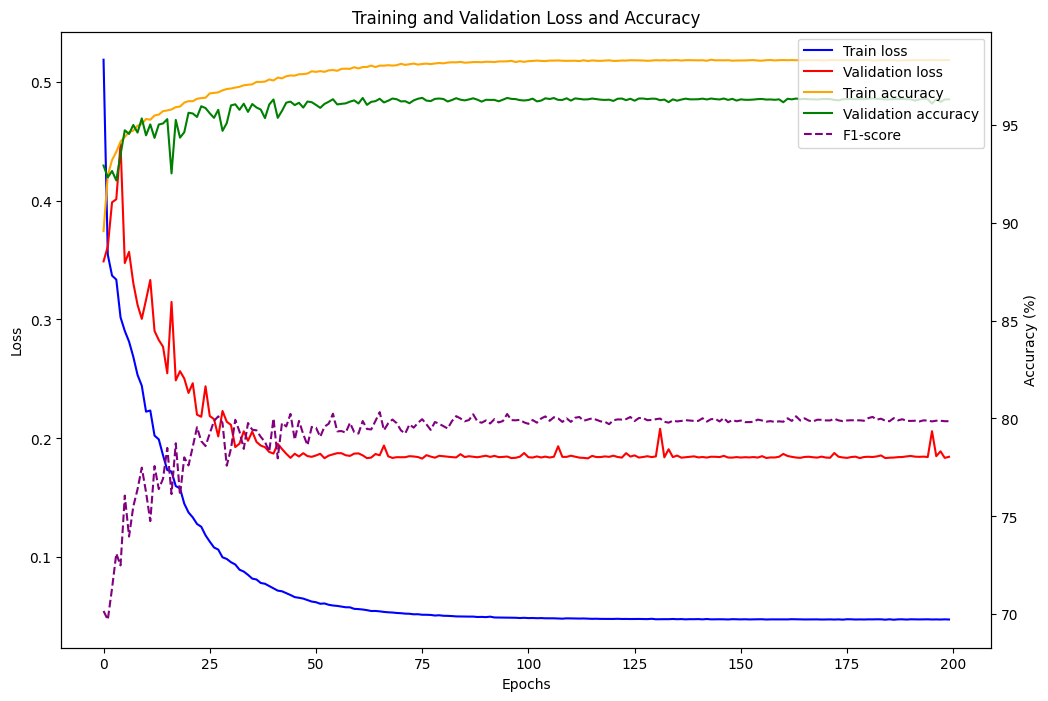

In [13]:

plt.figure(figsize=(12, 8))
plt.title(f"Training and Validation Loss and Accuracy")

# Plot training and validation loss
p1, = plt.plot(t1, label='Train loss', color='blue')
p2, = plt.plot(t4, label='Validation loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')

ax2 = plt.twinx()

# Plot training and validation accuracy
p3, = ax2.plot(t2, label='Train accuracy', color='orange')
p4, = ax2.plot(t3, label='Validation accuracy', color='green')
ax2.set_ylabel('Accuracy (%)')

# Plot test F1-score
p5, = ax2.plot(t5, label='F1-score', linestyle='dashed', color='purple')

# Combine legends
lines = [p1, p2, p3, p4, p5]
labels = [line.get_label() for line in lines]
plt.legend(lines, labels, loc='upper right')

plt.show()


Validation loss: 0.2079
Validation accuracy: 96.32%
Model saved as LogEucResNet_combo_d1_7.ckpt
                  precision    recall  f1-score   support

            corn       0.98      0.98      0.98      3818
      horsebeans       0.69      0.66      0.68        92
          meadow       0.99      0.99      0.99     10508
   spring_barley       0.51      0.56      0.53        78
     spring_peas       0.75      0.75      0.75        55
      sunflowers       0.88      0.89      0.88       254
   winter_barley       0.92      0.93      0.93       817
      winter_oat       0.41      0.29      0.34        87
 winter_rapeseed       0.98      0.95      0.97       762
winter_triticale       0.77      0.69      0.73       537
    winter_wheat       0.95      0.97      0.96      4198

        accuracy                           0.96     21206
       macro avg       0.80      0.79      0.79     21206
    weighted avg       0.96      0.96      0.96     21206



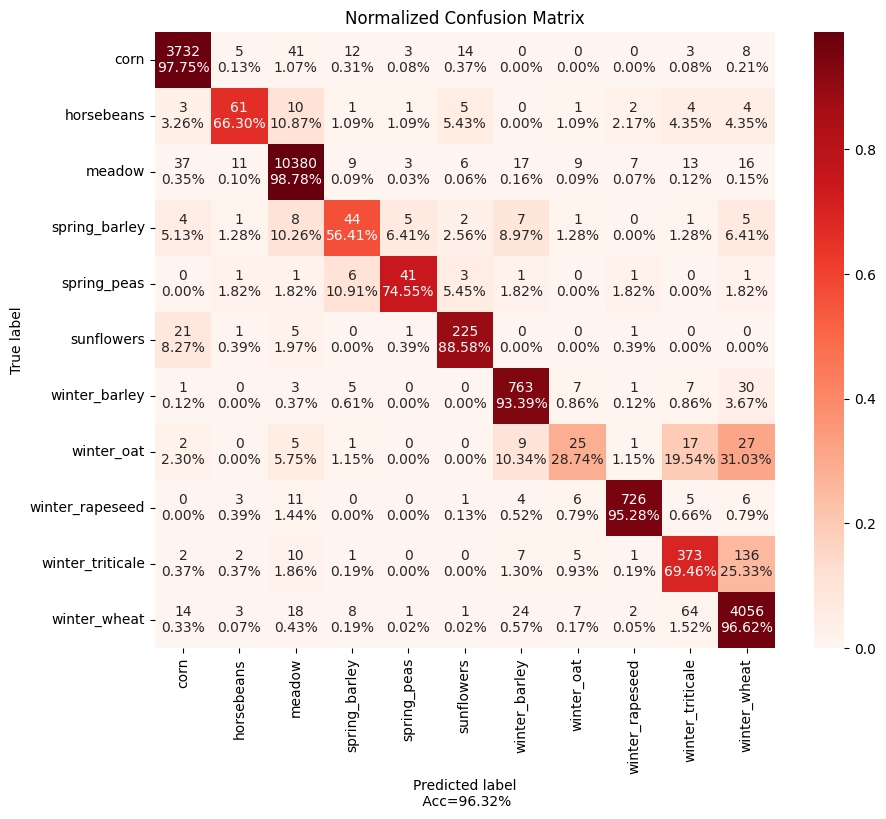

Figure saved as Confusion Matrix for LogEucResNet_combo_d1_7.png


96.32008146221249

In [14]:
evaluate_model(model, test_loader, loss_fn, "LogEucResNet_combo_d1_7", "Confusion Matrix for LogEucResNet_combo_d1_7", combo=True, temp=False)

Compute some TSNE visualization of the embedding

In [15]:
def gen_features(net, dataloader, combo=False, temp=True):
    net.eval()
    targets_list = []
    outputs_list = []

    with th.no_grad():
        for idx, (x1, x2, targets) in enumerate(dataloader):
            x1 = x1.to(device)
            x2 = x2.to(device)
            targets = targets.to(device)
            targets_np = targets.data.cpu().numpy()

            # Conditional forward pass
            if combo:
                outputs = net(x1, x2)
            elif temp:
                outputs = net(x1)
            else:
                outputs = net(x2)

            outputs_np = outputs.data.cpu().numpy()
            
            targets_list.append(targets_np[:, np.newaxis])
            outputs_list.append(outputs_np)
            
            if ((idx + 1) % 10 == 0) or (idx + 1 == len(dataloader)):
                print(idx + 1, '/', len(dataloader))

    targets = np.concatenate(targets_list, axis=0)
    outputs = np.concatenate(outputs_list, axis=0).astype(np.float64)

    return targets, outputs

def tsne_plot(save_dir, targets, outputs):
    print('generating t-SNE plot...')
    # tsne_output = bh_sne(outputs)
    tsne = TSNE(random_state=42, perplexity=50)
    tsne_output = tsne.fit_transform(outputs)

    df = pd.DataFrame(tsne_output, columns=['x', 'y'])
    df['targets'] = targets

    plt.rcParams['figure.figsize'] = 10, 10
    sns.scatterplot(
        x='x', y='y',
        hue='targets',
        palette=sns.color_palette("Paired", 11),
        data=df,
        marker='o',
        legend="full",
        alpha=0.5
    )

    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
    plt.legend(loc='best')
    plt.title('t-SNE plot of the embeddings: After training')

    #plt.savefig(os.path.join(save_dir,'tsne_mm_03.png'), bbox_inches='tight')
    print('done!')


10 / 332
20 / 332
30 / 332
40 / 332
50 / 332
60 / 332
70 / 332
80 / 332
90 / 332
100 / 332
110 / 332
120 / 332
130 / 332
140 / 332
150 / 332
160 / 332
170 / 332
180 / 332
190 / 332
200 / 332
210 / 332
220 / 332
230 / 332
240 / 332
250 / 332
260 / 332
270 / 332
280 / 332
290 / 332
300 / 332
310 / 332
320 / 332
330 / 332
332 / 332
generating t-SNE plot...
done!


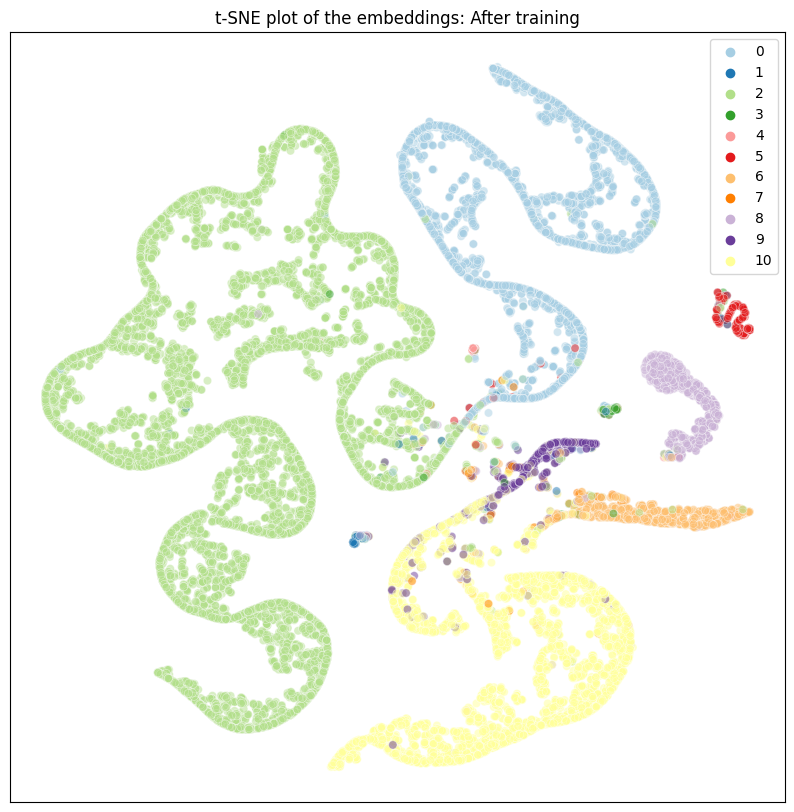

In [16]:
targets, outputs = gen_features(model,test_loader, combo =True)
tsne_plot('.',targets, outputs)